In [21]:
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import gala.dynamics as gd
import gala.potential as gp
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from scipy.optimize import minimize_scalar
from matplotlib.patches import Ellipse

Helper Functions

In [22]:
def sample(dict, ics):
    n_samples = 100
    ra_samples = np.random.normal(dict['ra'], dict['e_ra'], n_samples)
    dec_samples = np.random.normal(dict['dec'], dict['e_dec'], n_samples)
    dist_samples = np.random.normal(dict['dist'], dict['e_dist'], n_samples)
    pmra_samples = np.random.normal(dict['pmra'], dict['e_pmra'], n_samples)
    pmdec_samples = np.random.normal(dict['pmdec'], dict['e_pmdec'], n_samples)
    rv_samples = np.random.normal(dict['rv'], dict['e_rv'], n_samples)

    ics_list = []
    ics_list.append(ics)
    for ra, dec, dist, pmra, pmdec, rv in zip(ra_samples, dec_samples, dist_samples, pmra_samples, pmdec_samples, rv_samples):
        sc = coord.SkyCoord(ra=ra * u.degree,
                    dec=dec * u.degree,
                    distance=dist * u.kpc,
                    pm_ra_cosdec=pmra * (u.mas / u.yr),
                    pm_dec=pmdec * (u.mas / u.yr),
                    radial_velocity=rv * (u.km / u.s),
                    frame="icrs")
        gc = sc.transform_to(coord.Galactocentric)
        ics = gd.PhaseSpacePosition(pos=gc.cartesian.xyz, vel=gc.velocity.d_xyz)
        ics_list.append(ics)
    
    return ics_list

def calculate_orbits(dict, ics, num_steps):
    ics_list = sample(dict, ics)

    orbits = []
    orbits.append(orbit)
    for ics in ics_list:
        orbit = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=num_steps)
        orbits.append(orbit)

    return orbits

def plot_ellipse(x_vals, y_vals):
    pos = np.column_stack((x_vals, y_vals))
    mean = np.mean(pos, axis=0)
    cov = np.cov(pos, rowvar=False)

    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.scatter(x_vals, y_vals, s=3, color='red', alpha=0.5)

    # Confidence levels: 1σ (68%), 2σ (95%), 3σ (99.7%)
    for nsig in [1, 2, 3]:
        width, height = 2 * nsig * np.sqrt(eigvals)
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                          edgecolor='blue', fc='None', lw=2, label=f"{nsig}σ")
        ax.add_patch(ellipse)

    ax.set_xlabel(f"X [kpc]")
    ax.set_ylabel(f"Y [kpc]")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def calculate_distance(num_steps, ics):
    orbit = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=num_steps)
    final_z = orbit[-1].pos.xyz.to(u.kpc).value[2]
    return final_z

def plot_mw(dict, ics):
    ics_list = sample(dict, ics)

    points = []
    for ics in ics_list:
        result = minimize_scalar(
            calculate_distance,
            args=(ics),
            bounds=(0, 3000),  # search between 0 and 3000 steps (300 Myr)
            method='bounded'
        )
        orbit = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=result.x)
        final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:2]
        points.append(final_pos)

    points = np.array(points)

    x = points[:, 0]
    y = points[:, 1]

    plot_ellipse(x, y)

First, define a gravitational potential.

In [23]:
pot = gp.MilkyWayPotential()

Crater II

In [24]:
dwarf_dict = {
    'ra': 177.310, #degree
    'e_ra': 0.03, #degree
    'dec': -18.413, #degree
    'e_dec': 0.03, #degree
    'dist': 117.5, #kpc
    'e_dist': 1.1, #kpc
    'pmra': -0.07, #mas/yr
    'e_pmra': 0.02, #mas/yr
    'pmdec': -0.11, #mas/yr
    'e_pmdec': 0.01, #mas/yr
    'rv': 87.5, #km/s
    'e_rv': 0.4, #km/s
    }
dwarf = coord.SkyCoord(
    ra=dwarf_dict['ra'] * u.degree,
    dec=dwarf_dict['dec'] * u.degree,
    distance=dwarf_dict['dist'] * u.kpc,
    pm_ra_cosdec=dwarf_dict['pmra'] * (u.mas / u.yr),
    pm_dec=dwarf_dict['pmdec'] * (u.mas / u.yr),
    radial_velocity=dwarf_dict['rv'] * (u.km / u.s),
    frame="icrs"
)
dwarf_GC = dwarf.transform_to(coord.Galactocentric)
dwarf_ics = gd.PhaseSpacePosition(pos=dwarf_GC.cartesian.xyz, vel=dwarf_GC.velocity.d_xyz)

HVS 14

In [25]:
dict14 = {
    'ra': 161.0072805184, #degree
    'e_ra': 0.0001, #degree
    'dec': 6.1941762509, #degree
    'e_dec': 0.0001, #degree
    'dist': 102.66, #kpc
    'e_dist': 16.55, #kpc
    'pmra': -2.17, #mas/yr
    'e_pmra': 1.38, #mas/yr
    'pmdec': 2.28, #mas/yr
    'e_pmdec': 1.68, #mas/yr
    'rv': 537.30, #km/s
    'e_rv': 7.20, #km/s
    }
hvs14 = coord.SkyCoord(
    ra=dict14['ra'] * u.degree,
    dec=dict14['dec'] * u.degree,
    distance=dict14['dist'] * u.kpc,
    pm_ra_cosdec=dict14['pmra'] * (u.mas / u.yr),
    pm_dec=dict14['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict14['rv'] * (u.km / u.s),
    frame="icrs"
)
hvs14_GC = hvs14.transform_to(coord.Galactocentric)
hvs14_ics = gd.PhaseSpacePosition(pos=hvs14_GC.cartesian.xyz, vel=hvs14_GC.velocity.d_xyz)

Milky Way Plot (z=0)

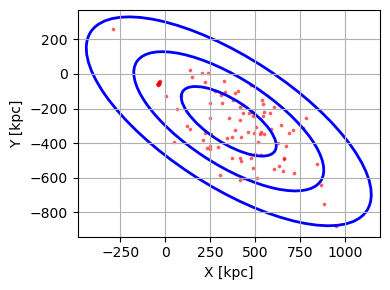

In [26]:
plot_mw(dict14, hvs14_ics)

Galaxy Plot

In [27]:
min14 = 366.5427377870987

orbits = calculate_orbits(dict14, hvs14_ics, min14)
dwarf_orbits = calculate_orbits(dwarf_dict, dwarf_ics, min14)

n_orbits = len(orbits)
colors = cm.viridis(np.linspace(0, 1, n_orbits))

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.3)

# XY
ax_xy = fig.add_subplot(gs[0, 0])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_xy.plot(pos[0], pos[1], color=colors[i], lw=0.1, alpha=0.7)
    ax_xy.scatter(pos[0, -1], pos[1, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[1], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[1, -1], color='black', marker='o', s=0.2)
ax_xy.set_xlabel('X [kpc]')
ax_xy.set_ylabel('Y [kpc]')
ax_xy.set_title('XY Projection')
ax_xy.axis('equal')
ax_xy.grid(True)

# XZ
ax_xz = fig.add_subplot(gs[0, 1])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_xz.plot(pos[0], pos[2], color=colors[i], lw=0.1, alpha=0.7)
    ax_xz.scatter(pos[0, -1], pos[2, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[0], pos[2], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[0, -1], pos[2, -1], color='black', marker='o', s=0.2)
ax_xz.set_xlabel('X [kpc]')
ax_xz.set_ylabel('Z [kpc]')
ax_xz.set_title('XZ Projection')
ax_xz.axis('equal')
ax_xz.grid(True)

# YZ
ax_yz = fig.add_subplot(gs[0, 2])
for i, orbit in enumerate(orbits):
    pos = orbit.pos.xyz.value
    ax_yz.plot(pos[1], pos[2], color=colors[i], lw=0.1, alpha=0.7)
    ax_yz.scatter(pos[1, -1], pos[2, -1], color=colors[i], marker='o', s=0.5)
for orbit in dwarf_orbits:
    pos = orbit.pos.xyz.value
    plt.plot(pos[1], pos[2], color='black', lw=0.1, alpha=0.5)
    plt.scatter(pos[1, -1], pos[2, -1], color='black', marker='o', s=0.2)
ax_yz.set_xlabel('Y [kpc]')
ax_yz.set_ylabel('Z [kpc]')
ax_yz.set_title('YZ Projection')
ax_yz.axis('equal')
ax_yz.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

UnboundLocalError: cannot access local variable 'orbit' where it is not associated with a value